# Lab 2

In [69]:
%matplotlib inline

import itertools
from IPython.display import display 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import statsmodels.formula.api as smf
import sys

sys.path.append('../src/')
import utils

mpl.rcParams['legend.fontsize'] = 'small'

In [70]:
def readmat_struct(filenm, struct_nm, ravel=True, dataframe=True, indexnm=None):
    data = sio.loadmat(filenm)
    nms = data[struct_nm].dtype.names
    output = {}
    for nm in nms:
        vals = data[struct_nm][nm][0, 0]
        if ravel:
            vals = vals.ravel()
        output[nm] = vals
    if dataframe:
        if indexnm is None:
            index = range(len(output[nms[0]]))
        else:
            index = output[indexnm]
            output.pop(indexnm)
        output = pd.DataFrame(output, index=index)
    return output

data = readmat_struct('glaciers.mat', 'glaciers', indexnm='WGMS ID')
data = data.rename(columns={nm : nm.replace(' ', '_') for nm in data.columns})

# Remove any rows with negative mass balance
data = data.iloc[np.where(data['g'] >= 0)[0]]

data.head()

,cloud_cover,continentality,g,lat,lon,max_elevation,median_elevation,precipitation,summer_temperature,winter_precipitation
2000,63.393750,8.395,8.102728,-54.78,-68.40,1172.5,1071.00,483.990,7.626667,36.273333
1305,61.731667,18.830,1.860170,47.04,12.97,2950.0,2660.00,1637.810,11.663333,91.578333
535,61.529583,20.045,9.194071,47.48,13.62,2910.0,2560.00,1521.845,14.881667,83.785000
491,62.957083,18.725,4.162200,46.80,10.77,3715.5,3039.75,1550.760,11.683333,93.790000
480,64.265417,17.855,4.411077,46.85,10.15,3140.0,2795.00,1726.480,10.561667,110.065000


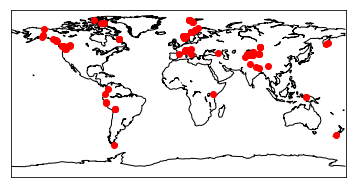

In [71]:
m = Basemap()
m.drawcoastlines()
m.plot(data['lon'], data['lat'], 'ro')

In [72]:
# Define predictors and response for MLR
response = 'g'
preds = data.columns
preds = preds.drop(response)

In [73]:
# Standardize predictor columns
data_st = utils.standardize(data, cols=preds)
data_st.head()

,cloud_cover,continentality,g,lat,lon,max_elevation,median_elevation,precipitation,summer_temperature,winter_precipitation
2000,-0.073330,-1.567918,8.102728,-4.510634,-0.917411,-1.305564,-1.127617,-1.008986,-0.610002,-0.826765
1305,-0.285946,-0.270948,1.860170,-0.009790,0.221562,0.000761,0.077903,0.634920,0.303656,0.080425
535,-0.311797,-0.119936,9.194071,0.009659,0.230660,-0.028636,0.002036,0.469699,1.032093,-0.047412
491,-0.129189,-0.283999,4.162200,-0.020399,0.190768,0.563344,0.366006,0.510896,0.308183,0.116703
480,0.038174,-0.392131,4.411077,-0.018189,0.182089,0.140396,0.180323,0.761253,0.054305,0.383669


In [74]:
formula = utils.get_formula(preds, response=response)
lm, Y_regr = utils.mlr(formula=formula, data=data_st)
data_st['Y_regr'] = Y_regr

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      g   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     8.532
Date:                Wed, 20 Sep 2017   Prob (F-statistic):           7.01e-10
Time:                        10:39:14   Log-Likelihood:                -313.61
No. Observations:                 135   AIC:                             647.2
Df Residuals:                     125   BIC:                             676.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                5.8058      0.221     26.284      0.000         5.369     6.243
cloud_cover              0.6228      0.422      1.475      0.143        -0.213     1.459
continentality          -0.3797      0.481     -0.789      0.431        -1.332     0.573
lat                     -0.9907      0.383     -2.584      0.011        -1.749    -0.232
lon                     -0.1568      0.278     -0.564      0.573        -0.706     0.393
max_elevation           -3.3376      1.120     -2.980      0.003        -5.554    -1.121
median_elevation         3.8693      1.265      3.059      0.003         1.366     6.373
precipitation           -1.7762      0.703     -2.527      0.013        -3.167    -0.385
summer_temperature      -0.0296      0.285     -0.104      0.917        -0.594     0.535
winter_precipitation     2.1524      0.685      3.140      0.002         0.796     3.509
==============================================================================
Omnibus:                       32.034   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.683
Skew:                           1.108   Prob(JB):                     1.34e-12
Kurtosis:                       5.192   Cond. No.                         14.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

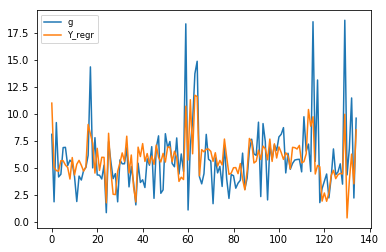

In [77]:
plt.plot(data_st[response].values, label=response)
plt.plot(data_st['Y_regr'].values, label='Y_regr')
plt.legend()

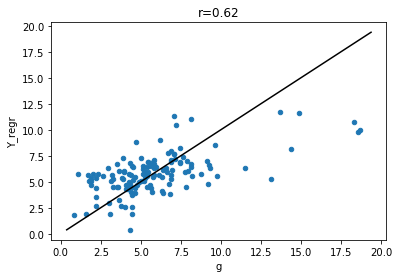

In [78]:
utils.scatterplot(data_st, response, 'Y_regr')

### Cross-validation

Split the data by selecting every other data point

In [86]:
data_cal = data_st.iloc[::2, :]
display(data_cal.head())
data_val = data_st.iloc[1::2, :]
data_val.head()

,cloud_cover,continentality,g,lat,lon,max_elevation,median_elevation,precipitation,summer_temperature,winter_precipitation,Y_regr
2000,-0.073330,-1.567918,8.102728,-4.510634,-0.917411,-1.305564,-1.127617,-1.008986,-0.610002,-0.826765,10.993175
535,-0.311797,-0.119936,9.194071,0.009659,0.230660,-0.028636,0.002036,0.469699,1.032093,-0.047412,4.748002
480,0.038174,-0.392131,4.411077,-0.018189,0.182089,0.140396,0.180323,0.761253,0.054305,0.383669,5.669172
547,-0.285946,-0.270948,6.901791,-0.009348,0.221282,0.096301,0.218256,0.634920,0.303656,0.080425,5.264637
583,-0.127430,-0.341794,5.717323,-0.006696,0.212044,0.467437,0.153769,0.669535,-0.066410,0.135622,3.969158


,cloud_cover,continentality,g,lat,lon,max_elevation,median_elevation,precipitation,summer_temperature,winter_precipitation,Y_regr
1305,-0.285946,-0.270948,1.860170,-0.009790,0.221562,0.000761,0.077903,0.634920,0.303656,0.080425,5.040832
491,-0.129189,-0.283999,4.162200,-0.020399,0.190768,0.563344,0.366006,0.510896,0.308183,0.116703,4.694106
507,-0.129189,-0.283999,6.880925,-0.019073,0.191048,0.398354,0.474938,0.510896,0.308183,0.116703,5.664906
510,-0.129189,-0.283999,5.220000,-0.021283,0.194127,0.346175,0.267569,0.510896,0.308183,0.116703,5.038391
483,0.038174,-0.392131,5.466395,-0.018189,0.181389,0.155095,0.267569,0.761253,0.054305,0.383669,5.957809


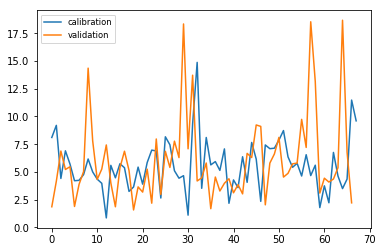

In [87]:
plt.plot(data_cal[response].values, label='calibration')
plt.plot(data_val[response].values, label='validation')
plt.legend()

In [83]:
formulas = utils.formula_list(preds, response=response)

In [84]:
output = utils.optimal_mlr(data_cal, data_val, data=data_st, formulas=formulas,
                           response=response, verbose=False)

In [90]:
formula_best = output['formula_best']
#lm_best = utils.mlr(formula=formula_best, data=data_cal)
display(output['lm_best'].summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      g   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     5.177
Date:                Wed, 20 Sep 2017   Prob (F-statistic):            0.00114
Time:                        10:43:32   Log-Likelihood:                -144.92
No. Observations:                  68   AIC:                             299.8
Df Residuals:                      63   BIC:                             310.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            5.6345      0.258     21.827      0.000         5.119     6.150
cloud_cover          0.9160      0.308      2.975      0.004         0.301     1.531
lat                 -0.4999      0.346     -1.446      0.153        -1.191     0.191
max_elevation       -2.5088      1.030     -2.436      0.018        -4.567    -0.451
median_elevation     2.6721      1.103      2.424      0.018         0.469     4.875
==============================================================================
Omnibus:                        2.273   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                1.520
Skew:                           0.236   Prob(JB):                        0.468
Kurtosis:                       3.560   Cond. No.                         9.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

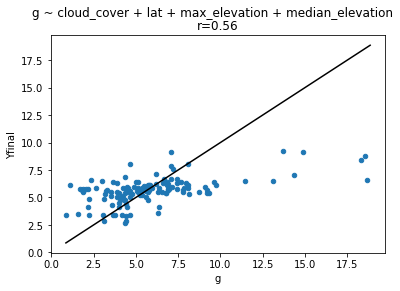

In [92]:
data_st['Yfinal'] = output['Yfinal']
utils.scatterplot(data_st, response, 'Yfinal')
plt.suptitle(output['formula_best'])

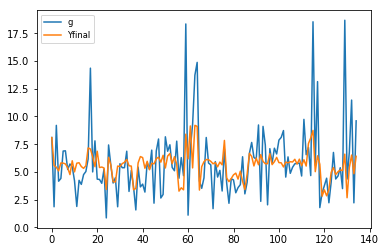

In [93]:
plt.plot(data_st[response].values, label=response)
plt.plot(data_st['Yfinal'].values, label='Yfinal')
plt.legend()